aggregate slurm result from unmf_within_minus_outside_one_exp
ie fit unmf, get within minus outside FR for each neuron, each field, each later day 

In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import database
reload(database)
db = database.thomas_18_db

In [314]:
figdir='/mnt/home/szheng/ceph/place_variability/fig/paper/figure_block_reuse'
figdir= misc.get_or_create_subdir(figdir)

In [4]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [5]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=False,bin_size=0.022,gauss_width=1,save_fn_one='fr_map_mask_True_smallbin.p',save_fn_all='fr_map_mask_True_smallbin.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin.p exists; loading---
CPU times: user 182 ms, sys: 5.58 s, total: 5.76 s
Wall time: 53.3 s


In [7]:
# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column

fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')

frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

In [8]:
reload(gtcm)
reload(pa)
per_cell_metrics=gtcm.get_variability_metrics(frmap,occu_map,fr_map_trial_df_all)

/mnt/home/szheng/projects/util_code/place_cell_analysis.py:213: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=frmap.loc[kk].dropna(axis=1)
/mnt/home/szheng/projects/util_code/place_cell_analysis.py:205: RuntimeWarning: invalid value encountered in true_divide
  div = (fr_map_v / fr_mean[:,None])


# aggregate slurm result

In [259]:
import unmf_within_minus_outside_one_exp as uwmooe
reload(uwmooe)
# load shuffle nmf result
import tqdm
db_grouped = uwmooe.db_grouped

pre_day_activation_all={}
field_range_ma_all={}
for i,(region,exp) in enumerate(tqdm.tqdm(db_grouped)):
    res=uwmooe.main(i,force_reload=False,dosave=False,load_only=True)
    pre_day_activation = res['pre_day_activation']
    field_range_ma_all[(region,exp)]=res['field_range_ma']
    pre_day_activation_all[(region,exp)] = pre_day_activation
pre_day_activation_all = pd.concat(pre_day_activation_all,axis=0)
field_range_ma_all = pd.concat(field_range_ma_all,axis=0)

 16%|█▌        | 5/31 [00:00<00:01, 18.19it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_1/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_3/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_4/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_5/unmf_withinoutsidediff_True.p exists; loading---


 26%|██▌       | 8/31 [00:00<00:01, 16.50it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_6/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_7/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_8/unmf_withinoutsidediff_True.p exists; loading---


 32%|███▏      | 10/31 [00:00<00:01, 11.82it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_9/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_10/unmf_withinoutsidediff_True.p exists; loading---


 39%|███▊      | 12/31 [00:00<00:01, 11.85it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_11/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_12/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_13/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_14/unmf_withinoutsidediff_True.p exists; loading---


 58%|█████▊    | 18/31 [00:01<00:00, 14.57it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_0/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_1/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_3/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_4/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_5/unmf_withinoutsidediff_True.p exists; loading---


 71%|███████   | 22/31 [00:01<00:00, 15.63it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA3/exp_6/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_0/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_1/unmf_withinoutsidediff_True.p exists; loading---


 81%|████████  | 25/31 [00:01<00:00, 16.89it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_3/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_4/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_5/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_6/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_7/unmf_withinoutsidediff_True.p exists; loading---


100%|██████████| 31/31 [00:01<00:00, 16.07it/s]

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_8/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_9/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_10/unmf_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/DG/exp_11/unmf_withinoutsidediff_True.p exists; loading---


In [ ]:
# average activation and difference across trials

In [28]:
pre_day_activation_all_avg_trial = pre_day_activation_all.mean(axis=1)
pre_day_activation_all_avg_trial = pre_day_activation_all_avg_trial.unstack(level=5)

In [ ]:
# do test per neuron

In [73]:
%%time
gpb=pre_day_activation_all.groupby(level=(0,1,2,3,4,6))
test_per_cell_all={}
for k,val in tqdm.tqdm(gpb):
    val=val.droplevel((0,1,2,3,4,6)).dropna(axis=1,how='all')
    test_per_cell_all[k]=scipy.stats.ranksums(val.loc['within'],val.loc['outside'])
# apply(lambda x:scipy.stats.ranksums(x.dropna(axis=1).loc['within'],x.dropna(axis=1).loc['outside']))
test_per_cell_all = pd.DataFrame(test_per_cell_all).T
test_per_cell_all.columns=['stat','p']


100%|██████████| 31343/31343 [00:43<00:00, 715.20it/s]


TypeError: cannot concatenate object of type '<class 'scipy.stats._stats_py.RanksumsResult'>'; only Series and DataFrame objs are valid

In [86]:
pre_day_activation_all_avg_trial,

diff   outside    within  diff_frac
CA1 0  0 0   1 0  0.063891  0.032223  0.096113   1.982791
               1  0.029446  0.027371  0.056817   1.075804
               2  0.012318  0.013568  0.025886   0.907904
             2 0  0.032630  0.042828  0.075458   0.761902
             3 1  0.060365  0.030518  0.090883   1.978009
...                    ...       ...       ...        ...
DG  11 1 211 1 0  0.015296  0.023495  0.038791   0.651007
             2 0 -0.034562  0.077891  0.043328  -0.443729
             3 0  0.038742  0.017653  0.056395   2.194662
             4 0  0.008213  0.036053  0.044267   0.227814
               1  0.005875  0.053828  0.059703   0.109152

[31343 rows x 4 columns]

In [89]:
pthresh = 0.05
test_per_cell_all['sig_more_within']=(test_per_cell_all['stat']>0) & (test_per_cell_all['p']<pthresh)
pre_day_activation_all_avg_trial=pd.concat([pre_day_activation_all_avg_trial,test_per_cell_all],axis=1)

In [42]:
pre_day_activation_all_avg_trial['diff_frac'] = (pre_day_activation_all_avg_trial['within']-pre_day_activation_all_avg_trial['outside']) / pre_day_activation_all_avg_trial['outside']

In [92]:
pre_day_activation_all_avg_trial['sig_more_within']

CA1  0   0  0    1  0     True
                    1     True
                    2    False
                 2  0     True
                 3  1     True
                         ...  
DG   11  1  211  1  0    False
                 2  0    False
                 3  0     True
                 4  0    False
                    1    False
Name: sig_more_within, Length: 31343, dtype: bool

RanksumsResult(statistic=35.971655053449204, pvalue=2.3217093886829375e-283)
RanksumsResult(statistic=29.03392132110686, pvalue=2.455939994860247e-185)
RanksumsResult(statistic=23.543206035637187, pvalue=1.4735602602370837e-122)
RanksumsResult(statistic=15.527453146986748, pvalue=2.261861058551105e-54)
RanksumsResult(statistic=22.34629810521352, pvalue=1.3117945059064865e-110)
RanksumsResult(statistic=25.833125484081403, pvalue=3.7655001207774707e-147)


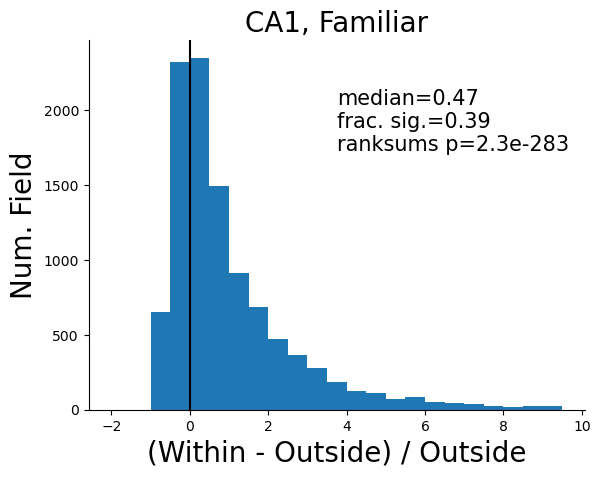

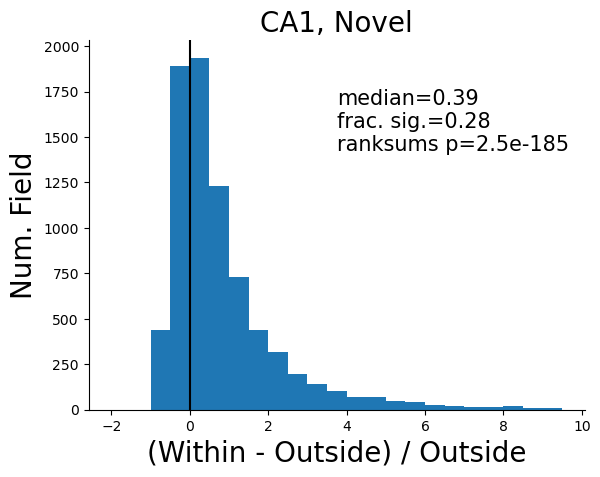

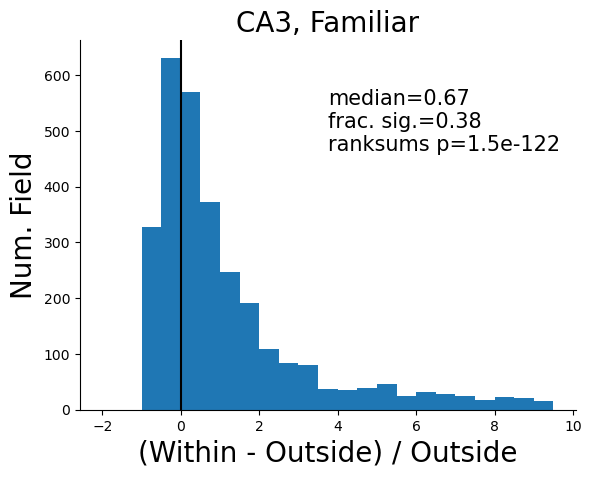

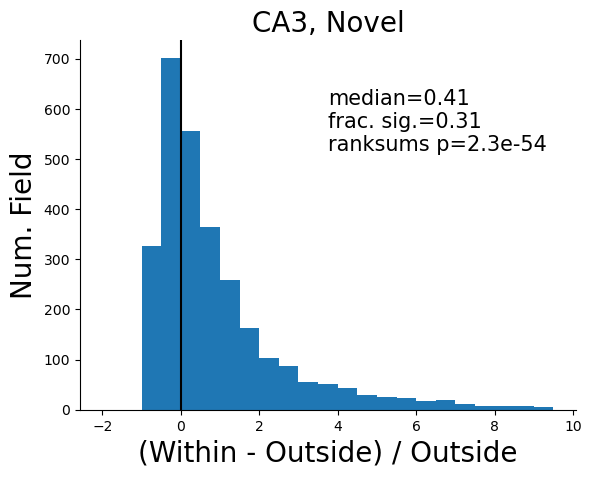

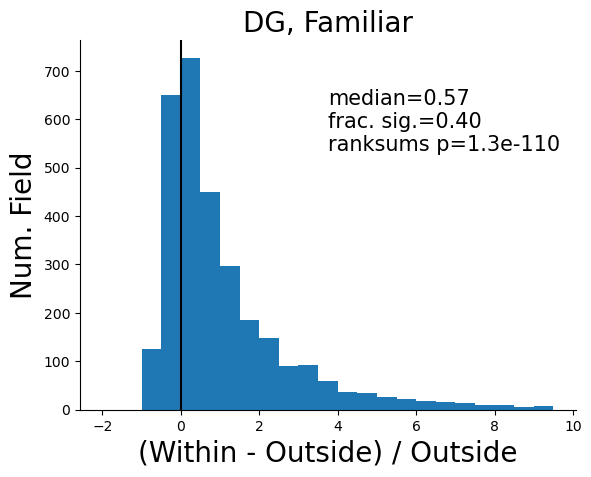

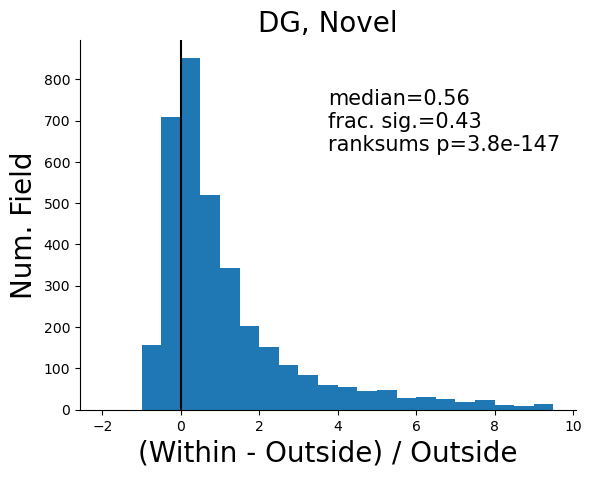

In [315]:
gpb=pre_day_activation_all_avg_trial.groupby(level=(0,2))
dosave=True
for (region,isnovel),_ in gpb:
# region='CA1'
# isnovel = 0
    xx=pre_day_activation_all_avg_trial.loc[region,slice(None),isnovel]
    population_test = scipy.stats.ranksums(xx['within'],xx['outside'])
    print(population_test)
    tohist_key='diff_frac'
    tohist_val=xx[tohist_key]
    fig,ax=plt.subplots()
    ax.hist(tohist_val,bins=np.arange(-2,10,0.5))
    median=tohist_val.median()
    frac_sig=xx['sig_more_within'].mean()
    sns.despine()
    ax.set(xlabel='(Within - Outside) / Outside',ylabel='Num. Field')
    text=f'median={median:.02f}\nfrac. sig.={frac_sig:.02f}\nranksums p={population_test.pvalue:.01e}'
    ax.axvline(0,color='k')
    ax.text(0.5,0.7,text,fontsize=15,transform=ax.transAxes)
    isnovel_str = ['Familiar','Novel'][isnovel]
    ax.set_title(f'{region}, {isnovel_str}')
    
    if dosave:
        for fmt in ['svg','png']:
            fig_fn = f'frac_increase_within_field_hist_{region}_{isnovel_str}.{fmt}'
            fig_fn_full = os.path.join(figdir,fig_fn)
            fig.savefig(fig_fn_full,bbox_inches='tight')
    

In [155]:
# reformat pre_day_activation_all_avg_trial into seaborn friendly for across region plots
pre_day_activation_all_avg_trial_toplot = pre_day_activation_all_avg_trial.reset_index(level=(0,1,2)).rename({'level_0':'region','level_1':'exp','level_2':'isnovel'},axis=1).reset_index(drop=True)



In [156]:
maxclip=pre_day_activation_all_avg_trial_toplot['diff_frac'].quantile(0.99)

In [157]:
pre_day_activation_all_avg_trial_toplot.loc[pre_day_activation_all_avg_trial_toplot['diff_frac'] > maxclip,'diff_frac'] = maxclip

(-3.0, 10.773477147919237)

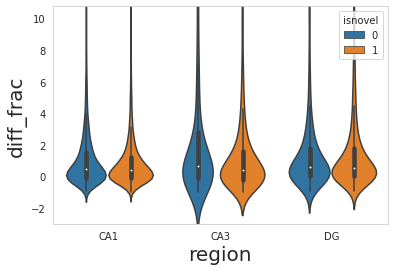

In [163]:
ax=sns.violinplot(data=pre_day_activation_all_avg_trial_toplot.dropna(axis=0),x='region',y='diff_frac',hue='isnovel')
ax.set_ylim([-3,maxclip/2])


In [172]:
pre_day_activation_all_avg_trial_toplot['sig_more_within'].mean()

0.35912324921035

<Axes: xlabel='region', ylabel='sig_more_within'>

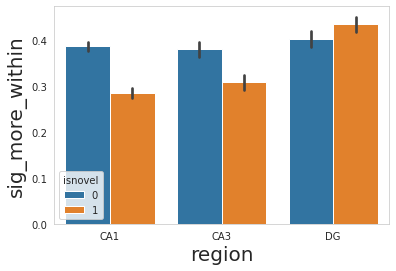

In [176]:
pre_day_activation_all_avg_trial_toplot['sig_more_within']=pre_day_activation_all_avg_trial_toplot['sig_more_within'].astype('float')
sns.barplot(data=pre_day_activation_all_avg_trial_toplot,x='region',y='sig_more_within',hue='isnovel')



# demonstrating pipeline
a fitting plot
3 examples of block reuse (include fitting)
same example can be used for nmf?



In [ ]:
import reuse_block_analysis as rba

In [266]:
field_range_ma_all

start  end  window_start  window_end
CA1 0  0 0   1 0      0   26             0          51
               1     51   68            43          76
               2     80   96            68          96
             2 0      6   38             0          54
             3 1     14   34            13          44
...                 ...  ...           ...         ...
DG  11 1 211 1 0     31   96             0          96
             2 0      0   54             0          96
             3 0     12   96             0          96
             4 0      7   45             0          54
               1     54   96            45          96

[31343 rows x 4 columns]

In [269]:
field_range_ma_all.loc[region,exp,isnovel,uid,get_field_day]

,start,end,window_start,window_end
1,6,71,14,92


In [327]:
row

diff                0.192191
outside             0.012817
within              0.205009
diff_frac          14.994623
stat                5.507571
p                        0.0
sig_more_within         True
Name: (153, 3, 1), dtype: object

In [386]:
region='CA1'
isnovel=0
exp = 0#10
ii=2
row=pre_day_activation_all_avg_trial.loc[region,exp,isnovel].sort_values('diff_frac',ascending=False).iloc[ii]
print(row)
uid,get_field_day,field_id=row.name
field_one=field_range_ma_all.loc[region,exp,isnovel,uid,get_field_day]
print(field_one)


diff                0.152518
outside             0.011095
within              0.163612
diff_frac          13.746965
stat                5.841908
p                        0.0
sig_more_within         True
Name: (440, 1, 0), dtype: object
   start  end  window_start  window_end
0     28   57            14          71
1     80   96            64          96


In [406]:
region=region
exp=0
uid=64
get_field_day=3

In [407]:
# exp_ind=('CA1',slice(None),0)
per_cell_metrics_oneexp = per_cell_metrics.loc[exp_ind,:]
# row=per_cell_metrics_oneexp.query('si>1').sample(1,random_state=3)
print(row)
# region, exp, day,isnovel,uid=ind=row.index[0]
# uid=40
# region,exp = exp_ind

# region = 'CA1'#'CA3'
# exp = 0#0
# uid = 64#21
# isnovel = 0#1

# prep all days
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
# X_df_ = X_df_.fillna(axis=0,method='ffill')
# maxval = np.quantile(X_df_.dropna(),0.99)
# X_df_[X_df_ > maxval] = X_df_

# get_field_day = 3
compare_day = 0#2

# X_df_compare = X_df_.loc[:,[compare_day]]

X_df_field = X_df_.loc[:,[get_field_day]] # 
# X_df_field = X_df_# X_df_.loc[:,X_df_.columns.get_level_values(0)!=2] #
# norm_factor = np.quantile(X_df_field.dropna().values,0.99)
# X_df = X_df_field /norm_factor
X_df = X_df_field

reload(unmf)
n_basis = 20#20#20
# lam_beta=lam_beta_cross=20
lam_beta=lam_beta_cross=20.

# lam_beta=lam_beta_cross = 20.#1.
lam_h = 0.1
rtol=1e-3
# lam_beta_cross = 10.#0.1
norm_W='mean' # 'max'
W_hat_ma, H_hat_ma,X_hat, loss_history = unmf.do_unimodal_nmf_wrapper(X_df,ma_thresh=0.05,clip_ratio=0.99,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=rtol,
                                                                verbose=True,norm_H=None,norm_W=norm_W
                                                               )

recon = loss_history['reconstruction'].iloc[-1]

field_range=rba.get_field(W_hat_ma,extend=2,max_thresh=0.2,out_of_field_size_thresh=5)


diff                0.152518
outside             0.011095
within              0.163612
diff_frac          13.746965
stat                5.841908
p                        0.0
sig_more_within         True
Name: (440, 1, 0), dtype: object
iter0--tot: 196.25127, recon: 36.67915, reg_beta: 0.66818, reg_H: 8.99139, reg_beta_cross: 149.91255
iter1--tot: 250.94107, recon: 34.48181, reg_beta: 1.05489, reg_H: 7.45653, reg_beta_cross: 207.94783
iter2--tot: 247.45791, recon: 34.61770, reg_beta: 1.18142, reg_H: 6.72085, reg_beta_cross: 204.93795
iter3--tot: 253.54413, recon: 34.52231, reg_beta: 1.21737, reg_H: 6.61593, reg_beta_cross: 211.18853
iter4--tot: 255.29564, recon: 34.49606, reg_beta: 1.22773, reg_H: 6.58624, reg_beta_cross: 212.98561
iter5--tot: 255.79580, recon: 34.48866, reg_beta: 1.23069, reg_H: 6.57780, reg_beta_cross: 213.49865
iter6--tot: 255.93829, recon: 34.48656, reg_beta: 1.23153, reg_H: 6.57540, reg_beta_cross: 213.64480
iter7--tot: 255.97886, recon: 34.48596, reg_beta: 1.23177

In [408]:
field_range

(   start  end  window_start  window_end
 0      2   65             0          96,
    start  end  window_start  window_end
 0      2   65             0          96)

/mnt/home/szheng/projects/nmf_analysis/unimodal_nmf.py:383: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


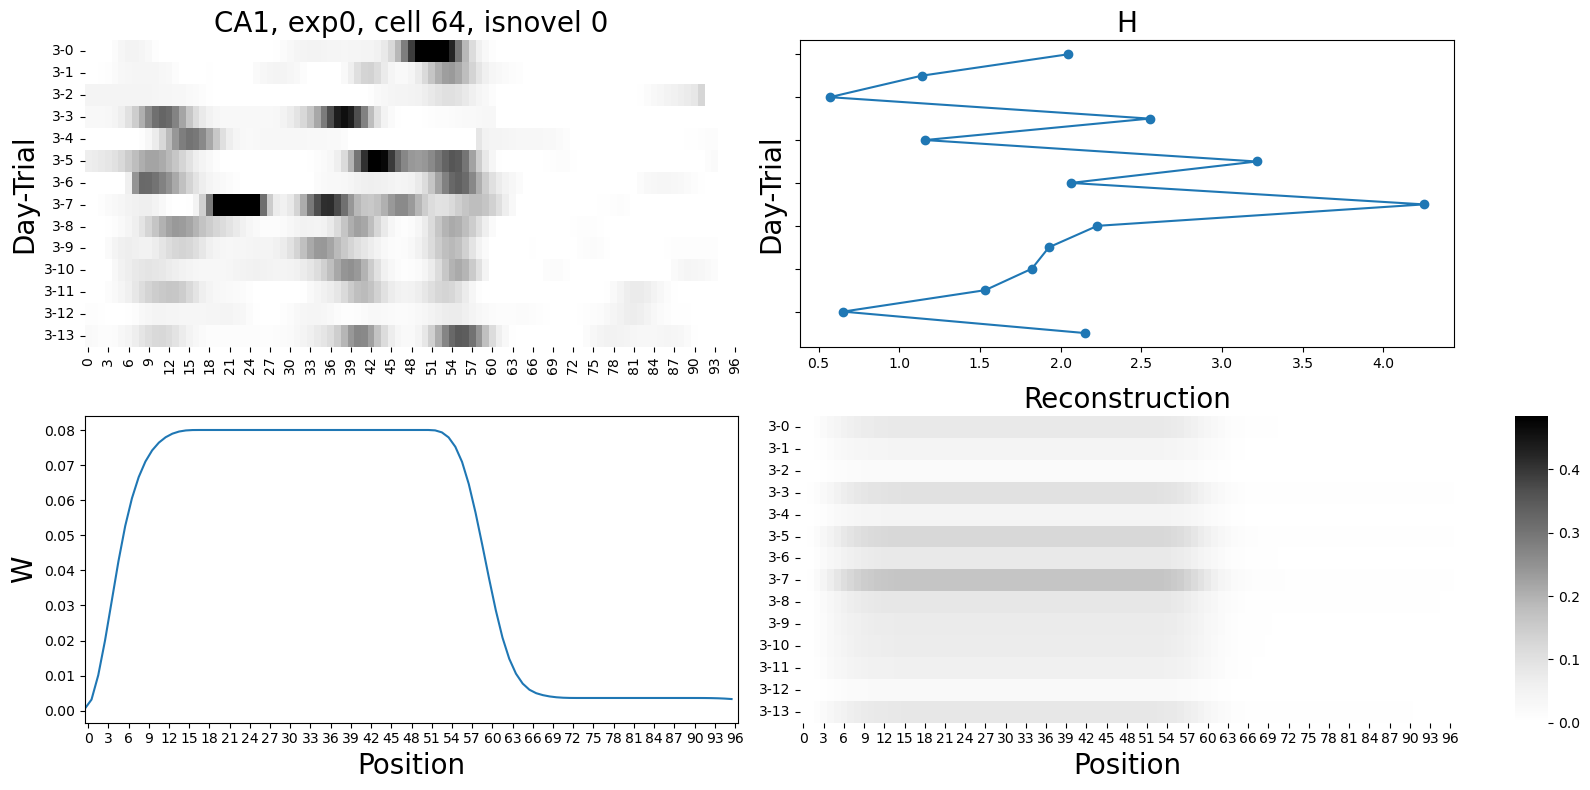

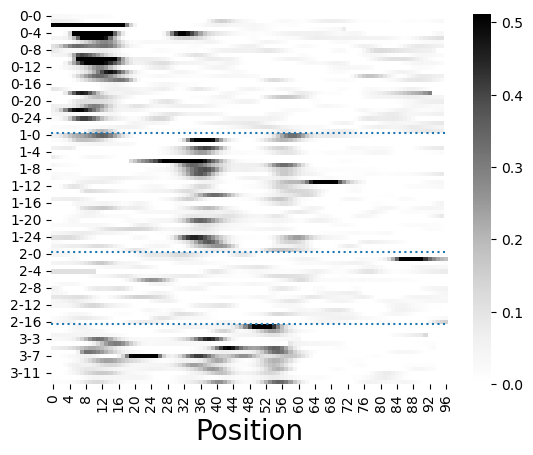

In [409]:
reload(unmf)
dosave = False
fig=unmf.plot_ratemap_and_wh(X_df_field,W_hat_ma,H_hat_ma,X_hat=X_hat,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)


if dosave:
    for fmt in ['svg','png']:
        fig_fn = f'good_ex_{region}_exp{exp}_uid{uid}_isnovel{isnovel}_day{get_field_day}_unmf.{fmt}'
        fig_fn_full=os.path.join(figdir,fig_fn)
        fig.savefig(fig_fn_full,bbox_inches='tight')
fig,ax=ph.heatmap(X_df_.T)
fig,ax=ph.plot_day_on_heatmap(X_df_.T,ax=ax,fig=fig)
if dosave:
    for fmt in ['svg','png']:
        fig_fn = f'good_ex_{region}_exp{exp}_uid{uid}_isnovel{isnovel}_allday.{fmt}'
        fig_fn_full=os.path.join(figdir,fig_fn)
        fig.savefig(fig_fn_full,bbox_inches='tight')


<Axes: >

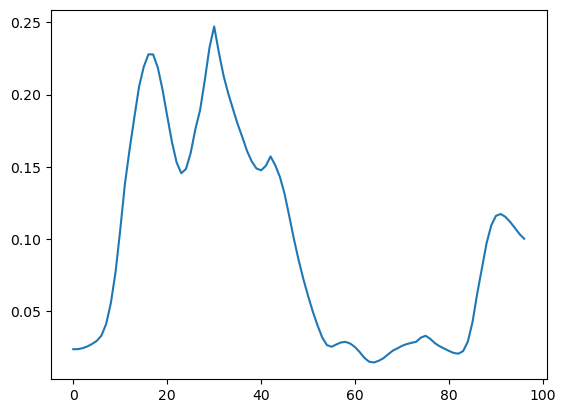

In [382]:
X_df.mean(axis=1).plot()

In [204]:

import matplotlib.gridspec as gridspec
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

In [210]:
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,0.05])

NameError: name 'region' is not defined

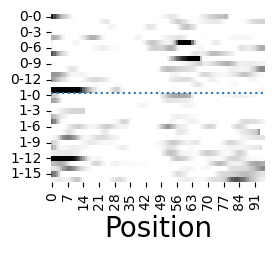

In [215]:
reload(unmf)
unmf.plot_ratemap_and_wh(X_df,W_hat_ma,H_hat_ma,X_hat=X_hat)

/tmp/ipykernel_908494/2121371722.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(gs[0, 0])
/tmp/ipykernel_908494/2121371722.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(gs[0, 1])
/tmp/ipykernel_908494/2121371722.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(gs[1, 0])
/tmp/ipykernel_908494/2121371722.py:23: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/tmp/ipykernel_908494/2121371722.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is 

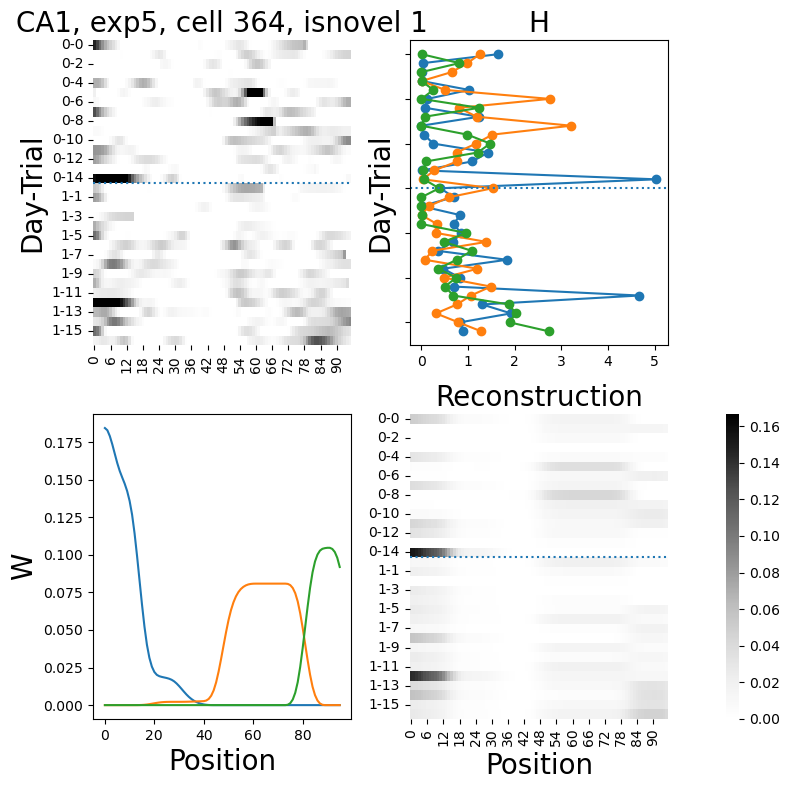

In [213]:
axs=None
if axs is None:
    fig,axs = plt.subplots(2,2,figsize=(8,8))
# ax=axs[0,0]
ax=plt.subplot(gs[0, 0])
# cbar_ax=plt.subplot(gs[0, 1])
fig,ax=ph.heatmap(X_df.T,ax=ax,vmax_quantile=0.99,cbar_ax=None,cbar=False)
vmin,vmax=ax.collections[0].get_clim()
ph.plot_day_on_heatmap(X_df,level=0,axis=1,ax=ax)
ax.set(ylabel='Day-Trial',title=f'{region}, exp{exp}, cell {uid}, isnovel {isnovel}',xlabel='')

# ax=axs[0,1]
ax=plt.subplot(gs[0, 1])
ax.invert_yaxis()
ax.plot(H_hat_ma.T,np.arange(H_hat_ma.shape[1]),marker='o')
ph.plot_day_on_heatmap(X_df,level=0,axis=1,ax=ax)
ax.set(ylabel='Day-Trial',yticklabels=[],title='H')


# ax=axs[1,0]
ax=plt.subplot(gs[1, 0])
ax.plot(W_hat_ma)
plt.tight_layout()
ax.set(xlabel='Position',ylabel='W')
if X_hat is not None:
#     ax = axs[1,1]
    ax=plt.subplot(gs[1, 1])
    cbar_ax = plt.subplot(gs[1,2])
    fig,ax=ph.heatmap(X_hat.T,ax=ax,vmax_quantile=0.99,cbar_ax=cbar_ax,vmin=vmin,vmax=vmax)
    ax.set_title('Reconstruction')
    ph.plot_day_on_heatmap(X_df,level=0,axis=1,ax=ax)
# else:
#     axs[1,1].remove()
plt.tight_layout()
# plt.subplots_adjust(hspace=0.3, wspace=0.5) 

In [56]:
scipy.stats.wilcoxon(xx['diff_frac'],alternative='greater')

WilcoxonResult(statistic=45760792.0, pvalue=0.0)

In [52]:
scipy.stats.ranksums(xx['within'],xx['outside'])

RanksumsResult(statistic=35.971655053449204, pvalue=2.3217093886829375e-283)

In [ ]:
xx[]

In [31]:
pre_day_activation_all_avg_trial_toplot

,region,exp,isnovel,diff,outside,within
0,CA1,0,0,0.063891,0.032223,0.096113
1,CA1,0,0,0.029446,0.027371,0.056817
2,CA1,0,0,0.012318,0.013568,0.025886
3,CA1,0,0,0.032630,0.042828,0.075458
4,CA1,0,0,0.060365,0.030518,0.090883
...,...,...,...,...,...,...
31338,DG,11,1,0.015296,0.023495,0.038791
31339,DG,11,1,-0.034562,0.077891,0.043328
31340,DG,11,1,0.038742,0.017653,0.056395
31341,DG,11,1,0.008213,0.036053,0.044267


diff   outside    within
CA1 0  0 0   1 0  0.063891  0.032223  0.096113
               1  0.029446  0.027371  0.056817
               2  0.012318  0.013568  0.025886
             2 0  0.032630  0.042828  0.075458
             3 1  0.060365  0.030518  0.090883
...                    ...       ...       ...
DG  11 1 211 1 0  0.015296  0.023495  0.038791
             2 0 -0.034562  0.077891  0.043328
             3 0  0.038742  0.017653  0.056395
             4 0  0.008213  0.036053  0.044267
               1  0.005875  0.053828  0.059703

[31343 rows x 3 columns]

# test slurm code

In [14]:
import unmf_within_minus_outside_one_exp as uwmooe
reload(uwmooe)

<module 'unmf_within_minus_outside_one_exp' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/unmf_within_minus_outside_one_exp.py'>

In [19]:
reload(rba)
region,exp,isnovel='CA1',0,0
uid=0
X_df_=fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')

pre_day_activation_d,W_hat_d,H_hat_d,field_range_d,field_range_ma_d = rba.fit_unmf_and_get_activation_all_comparisons_onecell(X_df_)




success=True
3
   start  end  window_start  window_end
0      0   23             0          18
1     18   34            23          42
2     80   96            72          96
   start  end  window_start  window_end
2     80   96            72          96
success=True
1
   start  end  window_start  window_end
0      5   40             0          57
   start  end  window_start  window_end
0      5   40             0          57
success=True
3
   start  end  window_start  window_end
0      0   12             0          16
1     16   32            12          40
2     51   67            43          75
   start  end  window_start  window_end
1     16   32            12          40
2     51   67            43          75


In [16]:
res=uwmooe.main(0,test_mode=True,dosave=False)

  0%|          | 0/1148 [00:00<?, ?it/s]

success=True
4
   start  end  window_start  window_end
0      1   22             0          18
1     18   34            22          42
2     52   74            41          80
3     80   96            74          96
   start  end  window_start  window_end
2     52   74            41          80
3     80   96            74          96
success=True
1
   start  end  window_start  window_end
0      6   39             0          55
   start  end  window_start  window_end
0      6   39             0          55


  0%|          | 1/1148 [00:03<57:40,  3.02s/it]

success=True
3
   start  end  window_start  window_end
0      0   13             0          16
1     16   32            13          40
2     52   68            44          76
   start  end  window_start  window_end
1     16   32            13          40
2     52   68            44          76
success=True
2
   start  end  window_start  window_end
0      4   28             0          40
1     46   68            35          79
   start  end  window_start  window_end
0      4   28             0          40
1     46   68            35          79
success=True
2
   start  end  window_start  window_end
0      0   14             0          28
1     29   79            14          96
   start  end  window_start  window_end
0      0   14             0          28
1     29   79            14          96


  0%|          | 2/1148 [00:06<1:04:42,  3.39s/it]

success=True
2
   start  end  window_start  window_end
0      3   28             0          40
1     47   63            39          71
   start  end  window_start  window_end
0      3   28             0          40
1     47   63            39          71
success=True
3
   start  end  window_start  window_end
0      0   28             0          21
1     21   57            28          75
2     78   96            60          96
   start  end  window_start  window_end
1     21   57            28          75
2     78   96            60          96


100%|██████████| 1148/1148 [00:10<00:00, 107.05it/s]

success=True
3
   start  end  window_start  window_end
0      0   28             0          24
1     24   66            28          49
2     49   96            66          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


In [19]:
pre_day_activation=res['pre_day_activation']

# unimodal nmf

In [11]:
import reuse_block_analysis as rba

In [87]:
exp_ind=('CA1',0,slice(None),0)
per_cell_metrics_oneexp = per_cell_metrics.loc[exp_ind,:]
per_cell_metrics_oneexp_sub=per_cell_metrics_oneexp.query('si>1')


In [92]:
uid_l = per_cell_metrics_oneexp_sub.index.get_level_values(4).unique()

In [111]:
per_cell_metrics.loc[('CA1',0,slice(None),0,64),:]

si     fr_cv   mean_fr  sparsity
CA1 0 0 0 64  1.151387  1.143971  0.064191  3.520962
      1 0 64  0.863235  0.574569  0.046096  2.634138
      2 0 64  0.304611  0.517207  0.029813  1.401361
      3 0 64  0.724446  0.514095  0.061977  1.952318

In [112]:
reload(rba)
reload(unmf)
import tqdm
region,exp,_,isnovel=exp_ind
pre_day_activation_d_all = {}
for uid in tqdm.tqdm(uid_l[:100]):
    X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')    
    try:
        pre_day_activation_d = rba.fit_unmf_and_get_activation_all_comparisons_onecell(X_df_)
        pre_day_activation_d_all[uid] = pre_day_activation_d
    except:
        pass
pre_day_activation_d_all = pd.concat(pre_day_activation_d_all,axis=0)

  1%|          | 1/100 [00:01<03:16,  1.99s/it]

success=True
4
   start  end  window_start  window_end
0      0   23             0          17
1     17   46            23          40
2     40   90            46          85
3     85   96            90          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


  2%|▏         | 2/100 [00:03<02:57,  1.81s/it]

success=True
2
   start  end  window_start  window_end
0      2   17             0          12
1     12   29            17          37
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   26             0          25
1     25   66            26          66
2     66   87            66          96
   start  end  window_start  window_end
2     66   87            66          96


  3%|▎         | 3/100 [00:11<07:13,  4.47s/it]

success=True
3
   start  end  window_start  window_end
0      0   37             0          21
1     21   96            37          46
2     46   68            96          79
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


  4%|▍         | 4/100 [00:13<05:31,  3.45s/it]

success=True
4
   start  end  window_start  window_end
0      0   11             0           7
1      7   34            11          30
2     30   83            34          80
3     80   96            83          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0      0   12             0          22
1     22   60            12          79
   start  end  window_start  window_end
0      0   12             0          22
1     22   60            12          79
success=True
3
   start  end  window_start  window_end
0      0   56             0          60
1     60   77            56          85
2     86   96            77          96
   start  end  window_start  window_end
1     60   77            56          85
2     86   96            77          96


  5%|▌         | 5/100 [00:16<05:11,  3.28s/it]

success=True
2
   start  end  window_start  window_end
0      0   23             0          19
1     19   48            23          62
   start  end  window_start  window_end
1     19   48            23          62
success=True
3
   start  end  window_start  window_end
0     30   57            17          63
1     63   79            57          85
2     85   96            79          96
   start  end  window_start  window_end
0     30   57            17          63
1     63   79            57          85
2     85   96            79          96
success=True
1
   start  end  window_start  window_end
0     57   81            45          93
   start  end  window_start  window_end
0     57   81            45          93


  6%|▌         | 6/100 [00:18<04:33,  2.90s/it]

success=True
3
   start  end  window_start  window_end
0      0   12             0          12
1     12   55            12          76
2     85   96            74          96
   start  end  window_start  window_end
1     12   55            12          76
2     85   96            74          96


  7%|▋         | 7/100 [00:19<03:47,  2.44s/it]

success=True
2
   start  end  window_start  window_end
0     18   40             7          29
1     29   51            40          62
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0     35   60            23          57
1     57   80            60          86
2     86   96            80          96
   start  end  window_start  window_end
0     35   60            23          57
2     86   96            80          96


  8%|▊         | 8/100 [00:22<04:01,  2.62s/it]

success=True
2
   start  end  window_start  window_end
0      0   57             0          57
1     57   96            57          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0      0    7             0          14
1     16   45             7          59
   start  end  window_start  window_end
0      0    7             0          14
1     16   45             7          59
success=True
1
   start  end  window_start  window_end
0      0   74             0          96
   start  end  window_start  window_end
0      0   74             0          96


  9%|▉         | 9/100 [00:24<03:39,  2.41s/it]

success=True
1
   start  end  window_start  window_end
0     23   39            15          47
   start  end  window_start  window_end
0     23   39            15          47


 10%|█         | 10/100 [00:25<02:49,  1.88s/it]

success=True
6
   start  end  window_start  window_end
0      0    9             0           8
1      8   28             9          25
2     25   40            28          43
3     43   63            40          57
4     57   84            63          85
5     85   96            84          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0     10   34             0          46
   start  end  window_start  window_end
0     10   34             0          46


 11%|█         | 11/100 [00:27<02:59,  2.01s/it]

success=True
2
   start  end  window_start  window_end
0      0   59             0          62
1     62   96            59          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0    8             0          16
1     20   74             8          77
2     77   96            74          96
   start  end  window_start  window_end
0      0    8             0          16
1     20   74             8          77


 12%|█▏        | 12/100 [00:29<02:56,  2.01s/it]

success=True
success=True
1
   start  end  window_start  window_end
0      0   29             0          58
   start  end  window_start  window_end
0      0   29             0          58
success=True
2
   start  end  window_start  window_end
0      0   23             0          46
1     47   90            26          96
   start  end  window_start  window_end
0      0   23             0          46
1     47   90            26          96


 13%|█▎        | 13/100 [00:33<03:27,  2.39s/it]

success=True
2
   start  end  window_start  window_end
0      1   64             0          51
1     51   96            64          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   22             0          27
1     27   46            22          52
2     52   74            46          85
   start  end  window_start  window_end
1     27   46            22          52
2     52   74            46          85


 14%|█▍        | 14/100 [00:35<03:19,  2.31s/it]

success=True
2
   start  end  window_start  window_end
0      0   64             0          52
1     52   96            64          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0    5             0           4
1      4   28             5          29
2     29   57            28          71
   start  end  window_start  window_end
2     29   57            28          71
success=True
3
   start  end  window_start  window_end
0      0   12             0          24
1     33   79            12          74
2     74   96            79          96
   start  end  window_start  window_end
0      0   12             0          24
1     33   79            12          74


 15%|█▌        | 15/100 [00:39<04:04,  2.88s/it]

success=True
3
   start  end  window_start  window_end
0      0   24             0          29
1     29   62            24          51
2     51   96            62          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0      0   25             0          50
   start  end  window_start  window_end
0      0   25             0          50


 16%|█▌        | 16/100 [00:41<03:45,  2.69s/it]

success=True


 17%|█▋        | 17/100 [00:42<02:57,  2.14s/it]

success=True
3
   start  end  window_start  window_end
0      0   24             0          17
1     17   80            24          69
2     69   96            80          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   21             0          18
1     18   61            21          62
2     62   86            61          96
   start  end  window_start  window_end
2     62   86            61          96


 18%|█▊        | 18/100 [00:44<03:03,  2.24s/it]

success=True
3
   start  end  window_start  window_end
0      0   23             0          19
1     19   83            23          63
2     63   96            83          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 19%|█▉        | 19/100 [00:47<03:14,  2.40s/it]

success=True
4
   start  end  window_start  window_end
0      0   10             0           7
1      7   69            10          67
2     67   90            69          85
3     85   96            90          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0     29   52            18          63
   start  end  window_start  window_end
0     29   52            18          63
success=True
2
   start  end  window_start  window_end
0      0   15             0          30
1     46   96            15          96
   start  end  window_start  window_end
0      0   15             0          30
1     46   96            15          96


 20%|██        | 20/100 [00:52<04:01,  3.01s/it]

success=True
2
   start  end  window_start  window_end
0      0   61             0          68
1     68   93            61          96
   start  end  window_start  window_end
0      0   61             0          68
1     68   93            61          96


 21%|██        | 21/100 [00:53<03:17,  2.50s/it]

success=True
4
   start  end  window_start  window_end
0      0   37             0          36
1     36   52            37          46
2     46   90            52          88
3     88   96            90          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 22%|██▏       | 22/100 [00:54<02:33,  1.97s/it]

success=True
2
   start  end  window_start  window_end
0      0   68             0          57
1     57   85            68          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 23%|██▎       | 23/100 [00:55<02:23,  1.86s/it]

success=True
5
   start  end  window_start  window_end
0      0   11             0           7
1      7   33            11          32
2     32   55            33          51
3     51   63            55          63
4     63   96            63          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   13             0          12
1     12   35            13          46
2     63   85            52          96
   start  end  window_start  window_end
1     12   35            13          46
2     63   85            52          96


 24%|██▍       | 24/100 [00:57<02:21,  1.86s/it]

success=True
3
   start  end  window_start  window_end
0      0   10             0           8
1      8   51            10          46
2     46   96            51          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   18             0          36
1     59   79            49          78
2     78   96            79          96
   start  end  window_start  window_end
0      0   18             0          36
1     59   79            49          78


 25%|██▌       | 25/100 [00:59<02:19,  1.86s/it]

success=True
3
   start  end  window_start  window_end
0      0   17             0          13
1     13   68            17          64
2     64   96            68          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   23             0          20
1     20   40            23          46
2     46   74            40          88
   start  end  window_start  window_end
2     46   74            40          88
success=True
2
   start  end  window_start  window_end
0      0   16             0          25
1     25   96            16          96
   start  end  window_start  window_end
0      0   16             0          25
1     25   96            16          96


 26%|██▌       | 26/100 [01:02<02:36,  2.12s/it]

success=True
5
   start  end  window_start  window_end
0      0   10             0           7
1      7   28            10          26
2     26   52            28          46
3     46   64            52          73
4     81   96            66          96
   start  end  window_start  window_end
4     81   96            66          96


 27%|██▋       | 27/100 [01:02<02:02,  1.68s/it]

success=True
2
   start  end  window_start  window_end
0      0   68             0          68
1     68   96            68          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0      5   30             0          42
   start  end  window_start  window_end
0      5   30             0          42


 28%|██▊       | 28/100 [01:04<02:08,  1.79s/it]

success=True
success=True
2
   start  end  window_start  window_end
0      0   19             0          38
1     51   96            19          96
   start  end  window_start  window_end
0      0   19             0          38
1     51   96            19          96
success=True
2
   start  end  window_start  window_end
0      0   23             0          23
1     23   51            23          65
   start  end  window_start  window_end
1     23   51            23          65


 29%|██▉       | 29/100 [01:06<02:01,  1.71s/it]

success=True
1
   start  end  window_start  window_end
0     54   96            33          96
   start  end  window_start  window_end
0     54   96            33          96
success=True
3
   start  end  window_start  window_end
0      0   14             0          28
1     41   62            31          14
2     14   96            62          96
   start  end  window_start  window_end
0      0   14             0          28


 30%|███       | 30/100 [01:08<02:03,  1.77s/it]

success=True
2
   start  end  window_start  window_end
0      0   40             0          20
1     20   96            40          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 31%|███       | 31/100 [01:09<01:40,  1.46s/it]

success=True
3
   start  end  window_start  window_end
0      0   12             0          12
1     12   62            12          61
2     61   96            62          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 32%|███▏      | 32/100 [01:10<01:31,  1.35s/it]

success=True
3
   start  end  window_start  window_end
0      5   34             0          25
1     25   79            34          71
2     71   94            79          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0      1   20             0          29
   start  end  window_start  window_end
0      1   20             0          29
success=True
6
   start  end  window_start  window_end
0      0   17             0          12
1     12   29            17          31
2     31   46            29          51
3     51   67            46          62
4     62   77            67          74
5     74   88            77          95
   start  end  window_start  window_end
2     31   46            29          51


 33%|███▎      | 33/100 [01:13<02:00,  1.80s/it]

success=True
2
   start  end  window_start  window_end
0      1   23             0          18
1     18   77            23          96
   start  end  window_start  window_end
1     18   77            23          96
success=True
1
   start  end  window_start  window_end
0      0   23             0          46
   start  end  window_start  window_end
0      0   23             0          46


 34%|███▍      | 34/100 [01:15<02:02,  1.85s/it]

success=True
2
   start  end  window_start  window_end
0      0   17             0          13
1     13   96            17          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0      0   17             0          34
   start  end  window_start  window_end
0      0   17             0          34
success=True
3
   start  end  window_start  window_end
0      0   12             0          24
1     25   82            12          82
2     82   96            82          96
   start  end  window_start  window_end
0      0   12             0          24
1     25   82            12          82


 35%|███▌      | 35/100 [01:18<02:38,  2.44s/it]

success=True
1
   start  end  window_start  window_end
0      0   17             0          34
   start  end  window_start  window_end
0      0   17             0          34


 36%|███▌      | 36/100 [01:21<02:41,  2.53s/it]

success=True
3
   start  end  window_start  window_end
0      0   17             0          12
1     12   64            17          39
2     39   96            64          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 37%|███▋      | 37/100 [01:22<02:04,  1.97s/it]

success=True
2
   start  end  window_start  window_end
0      1   12             0           6
1      6   23            12          31
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 38%|███▊      | 38/100 [01:23<01:44,  1.68s/it]

success=True
4
   start  end  window_start  window_end
0      0   23             0          17
1     17   32            23          29
2     29   81            32          77
3     77   96            81          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0      6   25             0          34
   start  end  window_start  window_end
0      6   25             0          34


 39%|███▉      | 39/100 [01:25<01:51,  1.84s/it]

success=True
3
   start  end  window_start  window_end
0      0   21             0          23
1     23   40            21          41
2     41   96            40          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   10             0          20
1     51   74            40          85
2     86   96            76          96
   start  end  window_start  window_end
0      0   10             0          20
1     51   74            40          85
2     86   96            76          96
success=True
2
   start  end  window_start  window_end
0      0    7             0          13
1     13   57             7          79
   start  end  window_start  window_end
0      0    7             0          13
1     13   57             7          79


 40%|████      | 40/100 [01:27<02:01,  2.03s/it]

success=True
2
   start  end  window_start  window_end
0      0    9             0          18
1     45   96             9          96
   start  end  window_start  window_end
0      0    9             0          18
1     45   96             9          96


 41%|████      | 41/100 [01:29<01:42,  1.74s/it]

success=True
3
   start  end  window_start  window_end
0      0   17             0          18
1     18   84            17          80
2     80   96            84          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 42%|████▏     | 42/100 [01:30<01:27,  1.52s/it]

success=True
5
   start  end  window_start  window_end
0      0   10             0           3
1      3   34            10          25
2     25   73            34          59
3     59   91            73          86
4     86   96            91          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 43%|████▎     | 43/100 [01:31<01:26,  1.52s/it]

success=True
3
   start  end  window_start  window_end
0      0   26             0          12
1     12   85            26          80
2     80   96            85          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 44%|████▍     | 44/100 [01:33<01:28,  1.58s/it]

success=True
3
   start  end  window_start  window_end
0     18   35            10          29
1     29   44            35          40
2     40   55            44          62
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0      0   27             0          54
   start  end  window_start  window_end
0      0   27             0          54
success=True
3
   start  end  window_start  window_end
0      0   14             0          28
1     29   51            18          62
2     79   94            72          96
   start  end  window_start  window_end
0      0   14             0          28
1     29   51            18          62
2     79   94            72          96


 45%|████▌     | 45/100 [01:35<01:33,  1.70s/it]

success=True
1
   start  end  window_start  window_end
0      3   23             0          33
   start  end  window_start  window_end
0      3   23             0          33
success=True
4
   start  end  window_start  window_end
0      0   12             0          23
1     23   40            15          48
2     57   79            46          89
3     89   96            82          96
   start  end  window_start  window_end
0      0   12             0          23
1     23   40            15          48
2     57   79            46          89
3     89   96            82          96
success=True
2
   start  end  window_start  window_end
0      0   51             0          46
1     46   74            51          88
   start  end  window_start  window_end
1     46   74            51          88


 46%|████▌     | 46/100 [01:37<01:33,  1.73s/it]

success=True
1
   start  end  window_start  window_end
0     74   96            52          96
   start  end  window_start  window_end
0     74   96            52          96
success=True
6
   start  end  window_start  window_end
0      0    3             0           1
1      1   22             3          18
2     18   36            22          34
3     34   50            36          46
4     46   70            50          80
5     80   96            70          96
   start  end  window_start  window_end
4     46   70            50          80
5     80   96            70          96


 47%|████▋     | 47/100 [01:39<01:38,  1.87s/it]

success=True
2
   start  end  window_start  window_end
0      0   43             0          28
1     28   96            43          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 48%|████▊     | 48/100 [01:39<01:17,  1.49s/it]

success=True
4
   start  end  window_start  window_end
0      0   17             0          18
1     18   57            17          55
2     55   79            57          80
3     80   96            79          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0      6   27             0          35
1     35   96            27          96
   start  end  window_start  window_end
0      6   27             0          35
1     35   96            27          96
success=True
2
   start  end  window_start  window_end
0      0   58             0          64
1     64   96            58          96
   start  end  window_start  window_end
0      0   58             0          64
1     64   96            58          96


 49%|████▉     | 49/100 [01:42<01:37,  1.91s/it]

success=True
2
   start  end  window_start  window_end
0      3   17             0          24
1     28   61            17          77
   start  end  window_start  window_end
0      3   17             0          24
1     28   61            17          77
success=True
3
   start  end  window_start  window_end
0      2   30             0          34
1     34   57            30          68
2     74   91            66          96
   start  end  window_start  window_end
0      2   30             0          34
1     34   57            30          68
2     74   91            66          96
success=True
2
   start  end  window_start  window_end
0      2   46             0          61
1     61   93            46          96
   start  end  window_start  window_end
0      2   46             0          61
1     61   93            46          96


 50%|█████     | 50/100 [01:44<01:26,  1.73s/it]

success=True
3
   start  end  window_start  window_end
0      6   28             0          29
1     29   51            28          62
2     71   96            59          96
   start  end  window_start  window_end
0      6   28             0          29
1     29   51            28          62
2     71   96            59          96
success=True
3
   start  end  window_start  window_end
0     16   45             2          40
1     40   62            45          73
2     80   96            64          96
   start  end  window_start  window_end
0     16   45             2          40
1     40   62            45          73
2     80   96            64          96
success=True
2
   start  end  window_start  window_end
0     18   43             6          55
1     83   96            70          96
   start  end  window_start  window_end
0     18   43             6          55
1     83   96            70          96


 51%|█████     | 51/100 [01:46<01:31,  1.87s/it]

success=True
1
   start  end  window_start  window_end
0      0   89             0          96
   start  end  window_start  window_end
0      0   89             0          96


 52%|█████▏    | 52/100 [01:47<01:23,  1.74s/it]

success=True
1
   start  end  window_start  window_end
0      0   93             0          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
4
   start  end  window_start  window_end
0      0    7             0           3
1      3   34             7          23
2     23   52            34          66
3     76   96            56          96
   start  end  window_start  window_end
3     76   96            56          96
success=True
4
   start  end  window_start  window_end
0      0   16             0          14
1     14   38            16          36
2     36   68            38          63
3     63   85            68          96
   start  end  window_start  window_end
3     63   85            68          96


 53%|█████▎    | 53/100 [01:53<02:15,  2.88s/it]

success=True
3
   start  end  window_start  window_end
0      0   45             0          46
1     46   73            45          74
2     74   96            73          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0     63   81            54          90
   start  end  window_start  window_end
0     63   81            54          90
success=True
3
   start  end  window_start  window_end
0      0   30             0          42
1     42   62            32          63
2     63   86            62          96
   start  end  window_start  window_end
0      0   30             0          42
1     42   62            32          63
2     63   86            62          96


 54%|█████▍    | 54/100 [01:58<02:41,  3.50s/it]

success=True
2
   start  end  window_start  window_end
0      0   40             0          67
1     67   86            58          95
   start  end  window_start  window_end
0      0   40             0          67
1     67   86            58          95


 55%|█████▌    | 55/100 [02:01<02:31,  3.37s/it]

success=True
4
   start  end  window_start  window_end
0      0   28             0          23
1     23   62            28          59
2     59   90            62          87
3     87   96            90          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0      0   52             0          76
1     76   96            56          96
   start  end  window_start  window_end
0      0   52             0          76
1     76   96            56          96


 56%|█████▌    | 56/100 [02:04<02:22,  3.24s/it]

success=True
success=True
1
   start  end  window_start  window_end
0     29   51            18          62
   start  end  window_start  window_end
0     29   51            18          62
success=True
2
   start  end  window_start  window_end
0     33   57            21          69
1     86   96            76          96
   start  end  window_start  window_end
0     33   57            21          69
1     86   96            76          96


 57%|█████▋    | 57/100 [02:06<02:07,  2.97s/it]

success=True
3
   start  end  window_start  window_end
0      0   45             0          41
1     41   71            45          69
2     69   92            71          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0    7             0           3
1      3   76             7          86
2     86   96            76          96
   start  end  window_start  window_end
1      3   76             7          86
2     86   96            76          96
success=True
1
   start  end  window_start  window_end
0      7   35             0          49
   start  end  window_start  window_end
0      7   35             0          49


 58%|█████▊    | 58/100 [02:09<02:01,  2.90s/it]

success=True
3
   start  end  window_start  window_end
0      0   56             0          56
1     56   72            56          80
2     83   96            72          96
   start  end  window_start  window_end
1     56   72            56          80
2     83   96            72          96
success=True
1
   start  end  window_start  window_end
0      3   79             0          96
   start  end  window_start  window_end
0      3   79             0          96
success=True
2
   start  end  window_start  window_end
0      0   13             0          26
1     36   96            13          96
   start  end  window_start  window_end
0      0   13             0          26
1     36   96            13          96


 59%|█████▉    | 59/100 [02:12<02:03,  3.00s/it]

success=True
3
   start  end  window_start  window_end
0      0   29             0          23
1     23   52            29          66
2     85   96            74          96
   start  end  window_start  window_end
1     23   52            29          66
2     85   96            74          96


 60%|██████    | 60/100 [02:13<01:35,  2.38s/it]

success=True
3
   start  end  window_start  window_end
0      0   28             0          28
1     28   85            28          82
2     82   96            85          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 61%|██████    | 61/100 [02:14<01:19,  2.04s/it]

success=True
2
   start  end  window_start  window_end
0     22   45            11          35
1     35   96            45          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 62%|██████▏   | 62/100 [02:15<01:06,  1.75s/it]

success=True
3
   start  end  window_start  window_end
0      0   11             0           7
1      7   44            11          36
2     36   96            44          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 63%|██████▎   | 63/100 [02:17<01:09,  1.88s/it]

success=True
4
   start  end  window_start  window_end
0      0   31             0          18
1     18   51            31          46
2     46   79            51          84
3     84   96            79          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 64%|██████▍   | 64/100 [02:18<00:55,  1.55s/it]

success=True
2
   start  end  window_start  window_end
0      0   24             0          22
1     22   96            24          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   28             0          24
1     24   51            28          64
2     74   96            52          96
   start  end  window_start  window_end
1     24   51            28          64
2     74   96            52          96


 65%|██████▌   | 65/100 [02:20<01:01,  1.76s/it]

success=True
3
   start  end  window_start  window_end
0      0   23             0          12
1     12   64            23          57
2     57   90            64          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 66%|██████▌   | 66/100 [02:22<00:54,  1.61s/it]

success=True
5
   start  end  window_start  window_end
0      0    7             0           6
1      6   19             7          18
2     18   54            19          51
3     51   66            54          67
4     67   96            66          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0     34   62            20          63
1     63   96            62          96
   start  end  window_start  window_end
0     34   62            20          63
success=True
2
   start  end  window_start  window_end
0      9   55             0          63
1     63   86            55          96
   start  end  window_start  window_end
0      9   55             0          63
1     63   86            55          96


 67%|██████▋   | 67/100 [02:24<00:56,  1.71s/it]

success=True
2
   start  end  window_start  window_end
0      0   24             0          14
1     14   96            24          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
4
   start  end  window_start  window_end
0     28   45            20          40
1     40   57            45          63
2     63   79            57          84
3     84   96            79          96
   start  end  window_start  window_end
2     63   79            57          84
success=True
2
   start  end  window_start  window_end
0      7   55             0          79
1     86   96            76          96
   start  end  window_start  window_end
0      7   55             0          79
1     86   96            76          96


 68%|██████▊   | 68/100 [02:26<00:56,  1.76s/it]

success=True
1
   start  end  window_start  window_end
0     40   57            32          65
   start  end  window_start  window_end
0     40   57            32          65
success=True
2
   start  end  window_start  window_end
0      0   40             0          53
1     53   81            40          95
   start  end  window_start  window_end
0      0   40             0          53
1     53   81            40          95
success=True
2
   start  end  window_start  window_end
0      0   55             0          52
1     52   85            55          96
   start  end  window_start  window_end
1     52   85            55          96


 69%|██████▉   | 69/100 [02:29<01:11,  2.32s/it]

success=True
3
   start  end  window_start  window_end
0      0   29             0          35
1     35   57            29          57
2     57   82            57          94
   start  end  window_start  window_end
0      0   29             0          35
1     35   57            29          57
2     57   82            57          94
success=True
2
   start  end  window_start  window_end
0      5   34             0          46
1     46   68            35          79
   start  end  window_start  window_end
0      5   34             0          46
1     46   68            35          79


 70%|███████   | 70/100 [02:32<01:12,  2.40s/it]

success=True
success=True
3
   start  end  window_start  window_end
0      0    7             0           2
1      2   25             7          36
2     78   96            60          96
   start  end  window_start  window_end
1      2   25             7          36
2     78   96            60          96
success=True
2
   start  end  window_start  window_end
0      0   25             0          50
1     51   85            34          96
   start  end  window_start  window_end
0      0   25             0          50
1     51   85            34          96


 71%|███████   | 71/100 [02:34<01:11,  2.48s/it]

success=True
1
   start  end  window_start  window_end
0      0   31             0          62
   start  end  window_start  window_end
0      0   31             0          62


 72%|███████▏  | 72/100 [02:35<00:56,  2.01s/it]

success=True
3
   start  end  window_start  window_end
0      0   11             0          15
1     15   43            11          40
2     40   96            43          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 73%|███████▎  | 73/100 [02:36<00:47,  1.76s/it]

success=True
6
   start  end  window_start  window_end
0      0   11             0          13
1     13   40            11          34
2     34   46            40          40
3     40   62            46          55
4     55   85            62          80
5     80   96            85          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
5
   start  end  window_start  window_end
0      0   23             0          18
1     18   51            23          50
2     50   66            51          74
3     74   86            68          82
4     82   96            86          96
   start  end  window_start  window_end
2     50   66            51          74
success=True
3
   start  end  window_start  window_end
0      2   34             0          40
1     40   57            34          60
2     60   86            57          96
   start  end  window_start  window_end
0      2   34             0          40
1     40   57            34          60
2

 74%|███████▍  | 74/100 [02:38<00:46,  1.80s/it]

success=True
1
   start  end  window_start  window_end
0     40   66            27          79
   start  end  window_start  window_end
0     40   66            27          79


 75%|███████▌  | 75/100 [02:39<00:37,  1.48s/it]

success=True
2
   start  end  window_start  window_end
0      3   30             0          25
1     25   96            30          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 76%|███████▌  | 76/100 [02:41<00:41,  1.71s/it]

success=True
5
   start  end  window_start  window_end
0      0   17             0          12
1     12   34            17          32
2     32   62            34          56
3     56   89            62          85
4     85   96            89          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []


 77%|███████▋  | 77/100 [02:42<00:32,  1.43s/it]

success=True
4
   start  end  window_start  window_end
0      0   38             0          40
1     40   78            38          74
2     74   91            78          86
3     86   96            91          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   17             0          13
1     13   68            17          83
2     83   96            70          96
   start  end  window_start  window_end
1     13   68            17          83
2     83   96            70          96


 78%|███████▊  | 78/100 [02:43<00:30,  1.38s/it]

success=True
2
   start  end  window_start  window_end
0      0   58             0          52
1     52   96            58          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   77             0          14
1     14   34            77          44
2     82   96            68          96
   start  end  window_start  window_end
2     82   96            68          96
success=True
2
   start  end  window_start  window_end
0     14   57             0          78
1     87   96            78          96
   start  end  window_start  window_end
0     14   57             0          78
1     87   96            78          96


 79%|███████▉  | 79/100 [02:45<00:30,  1.45s/it]

success=True
1
   start  end  window_start  window_end
0     20   46             7          59
   start  end  window_start  window_end
0     20   46             7          59


 80%|████████  | 80/100 [02:47<00:32,  1.62s/it]

success=True
3
   start  end  window_start  window_end
0      0   13             0           9
1      9   82            13          80
2     80   96            82          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0     18   43             6          55
   start  end  window_start  window_end
0     18   43             6          55


 81%|████████  | 81/100 [02:50<00:36,  1.91s/it]

success=True
2
   start  end  window_start  window_end
0      0   38             0          42
1     42   96            38          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0      0   26             0          35
1     35   96            26          96
   start  end  window_start  window_end
0      0   26             0          35
1     35   96            26          96
success=True
1
   start  end  window_start  window_end
0     28   54            15          67
   start  end  window_start  window_end
0     28   54            15          67


 82%|████████▏ | 82/100 [02:51<00:32,  1.82s/it]

success=True
3
   start  end  window_start  window_end
0      0    8             0          16
1     18   76             8          70
2     70   96            76          96
   start  end  window_start  window_end
0      0    8             0          16
success=True
5
   start  end  window_start  window_end
0      0   12             0          12
1     12   56            12           7
2      7   28            56          38
3     57   91            40          88
4     88   96            91          96
   start  end  window_start  window_end
3     57   91            40          88


 83%|████████▎ | 83/100 [02:53<00:30,  1.78s/it]

success=True
4
   start  end  window_start  window_end
0      0   30             0          23
1     23   46            30          46
2     46   66            46          66
3     66   96            66          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0      0   20             0          40
1     46   64            37          73
   start  end  window_start  window_end
0      0   20             0          40
1     46   64            37          73
success=True
2
   start  end  window_start  window_end
0      0   42             0          43
1     43   69            42          82
   start  end  window_start  window_end
1     43   69            42          82


 84%|████████▍ | 84/100 [02:56<00:35,  2.20s/it]

success=True
3
   start  end  window_start  window_end
0      1   28             0          39
1     39   66            28          79
2     80   96            66          96
   start  end  window_start  window_end
0      1   28             0          39
1     39   66            28          79
2     80   96            66          96
success=True
1
   start  end  window_start  window_end
0     32   51            23          60
   start  end  window_start  window_end
0     32   51            23          60
success=True
1
   start  end  window_start  window_end
0     72   96            48          96
   start  end  window_start  window_end
0     72   96            48          96


 85%|████████▌ | 85/100 [03:00<00:38,  2.57s/it]

success=True
1
   start  end  window_start  window_end
0      0   18             0          36
   start  end  window_start  window_end
0      0   18             0          36


 86%|████████▌ | 86/100 [03:03<00:38,  2.74s/it]

success=True
2
   start  end  window_start  window_end
0      0   88             0          83
1     83   96            88          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   21             0          18
1     18   34            21          42
2     80   96            64          96
   start  end  window_start  window_end
2     80   96            64          96
success=True
1
   start  end  window_start  window_end
0      5   40             0          57
   start  end  window_start  window_end
0      5   40             0          57


 87%|████████▋ | 87/100 [03:06<00:35,  2.77s/it]

success=True
2
   start  end  window_start  window_end
0      0   17             0          17
1     17   34            17          42
   start  end  window_start  window_end
1     17   34            17          42
success=True
2
   start  end  window_start  window_end
0      4   28             0          40
1     51   67            43          75
   start  end  window_start  window_end
0      4   28             0          40
1     51   67            43          75
success=True
3
   start  end  window_start  window_end
0      0   15             0          30
1     35   67            19          63
2     63   96            67          96
   start  end  window_start  window_end
0      0   15             0          30
1     35   67            19          63


 88%|████████▊ | 88/100 [03:08<00:32,  2.73s/it]

success=True
2
   start  end  window_start  window_end
0      3   28             0          40
1     46   68            35          79
   start  end  window_start  window_end
0      3   28             0          40
1     46   68            35          79
success=True
1
   start  end  window_start  window_end
0     27   51            15          63
   start  end  window_start  window_end
0     27   51            15          63
success=True
2
   start  end  window_start  window_end
0      7   50             0          71
1     84   96            72          96
   start  end  window_start  window_end
0      7   50             0          71
1     84   96            72          96


 89%|████████▉ | 89/100 [03:11<00:30,  2.79s/it]

success=True
2
   start  end  window_start  window_end
0     23   51             9          63
1     63   83            53          93
   start  end  window_start  window_end
0     23   51             9          63
1     63   83            53          93
success=True
1
   start  end  window_start  window_end
0      1   18             0          26
   start  end  window_start  window_end
0      1   18             0          26


 90%|█████████ | 90/100 [03:13<00:24,  2.45s/it]

success=True
3
   start  end  window_start  window_end
0      0   37             0          39
1     39   62            37          63
2     63   96            62          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
3
   start  end  window_start  window_end
0      0   17             0          23
1     23   46            17          46
2     46   62            46          70
   start  end  window_start  window_end
0      0   17             0          23
1     23   46            17          46
2     46   62            46          70


 91%|█████████ | 91/100 [03:14<00:19,  2.17s/it]

success=True
4
   start  end  window_start  window_end
0      0    7             0           8
1      8   47             7          44
2     44   94            47          89
3     89   96            94          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0      3   23             0          12
1     12   49            23          67
   start  end  window_start  window_end
1     12   49            23          67
success=True
1
   start  end  window_start  window_end
0     26   78             0          96
   start  end  window_start  window_end
0     26   78             0          96


 92%|█████████▏| 92/100 [03:17<00:18,  2.30s/it]

success=True
3
   start  end  window_start  window_end
0      0   20             0          22
1     22   60            20          72
2     72   96            60          96
   start  end  window_start  window_end
1     22   60            20          72
2     72   96            60          96
success=True
2
   start  end  window_start  window_end
0      0   16             0          28
1     28   87            16          96
   start  end  window_start  window_end
0      0   16             0          28
1     28   87            16          96
success=True
3
   start  end  window_start  window_end
0      0   12             0          24
1     39   56            31          63
2     63   96            56          96
   start  end  window_start  window_end
0      0   12             0          24
1     39   56            31          63
2     63   96            56          96


 93%|█████████▎| 93/100 [03:19<00:16,  2.30s/it]

success=True
1
   start  end  window_start  window_end
0      0   41             0          82
   start  end  window_start  window_end
0      0   41             0          82
success=True
2
   start  end  window_start  window_end
0     11   32             1          42
1     84   96            72          96
   start  end  window_start  window_end
0     11   32             1          42
1     84   96            72          96


 94%|█████████▍| 94/100 [03:20<00:11,  1.95s/it]

success=True
2
   start  end  window_start  window_end
0      0   83             0          84
1     84   96            83          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
1
   start  end  window_start  window_end
0     41   58            33          66
   start  end  window_start  window_end
0     41   58            33          66
success=True
4
   start  end  window_start  window_end
0      0    7             0           5
1      5   45             7          40
2     40   62            45          59
3     59   80            62          90
   start  end  window_start  window_end
3     59   80            62          90


 95%|█████████▌| 95/100 [03:22<00:09,  1.95s/it]

success=True
1
   start  end  window_start  window_end
0     61   82            51          92
   start  end  window_start  window_end
0     61   82            51          92
success=True
3
   start  end  window_start  window_end
0      0   30             0          30
1     30   64            30          79
2     79   96            64          96
   start  end  window_start  window_end
1     30   64            30          79
2     79   96            64          96
success=True
2
   start  end  window_start  window_end
0     22   41            13          46
1     46   65            41          74
   start  end  window_start  window_end
0     22   41            13          46
1     46   65            41          74


 96%|█████████▌| 96/100 [03:25<00:08,  2.19s/it]

success=True
1
   start  end  window_start  window_end
0     72   91            63          96
   start  end  window_start  window_end
0     72   91            63          96
success=True
2
   start  end  window_start  window_end
0      0   14             0          28
1     36   61            24          73
   start  end  window_start  window_end
0      0   14             0          28
1     36   61            24          73
success=True
2
   start  end  window_start  window_end
0     26   46            16          46
1     46   66            46          76
   start  end  window_start  window_end
0     26   46            16          46
1     46   66            46          76


 97%|█████████▋| 97/100 [03:29<00:08,  2.87s/it]

success=True
3
   start  end  window_start  window_end
0     22   40            13          37
1     37   75            40          63
2     63   96            75          96
   start  end  window_start  window_end
0     22   40            13          37


 98%|█████████▊| 98/100 [03:31<00:04,  2.37s/it]

success=True
2
   start  end  window_start  window_end
0     50   78            36          63
1     63   94            78          96
Empty DataFrame
Columns: [start, end, window_start, window_end]
Index: []
success=True
2
   start  end  window_start  window_end
0      0   28             0          45
1     45   83            28          96
   start  end  window_start  window_end
0      0   28             0          45
1     45   83            28          96
success=True
3
   start  end  window_start  window_end
0     18   35            10          43
1     44   65            35          72
2     72   96            65          96
   start  end  window_start  window_end
0     18   35            10          43
1     44   65            35          72
2     72   96            65          96


 99%|█████████▉| 99/100 [03:33<00:02,  2.24s/it]

success=True
1
   start  end  window_start  window_end
0     45   62            37          70
   start  end  window_start  window_end
0     45   62            37          70
success=True
3
   start  end  window_start  window_end
0      1   14             0          20
1     27   46            18          55
2     79   96            62          96
   start  end  window_start  window_end
0      1   14             0          20
1     27   46            18          55
2     79   96            62          96
success=True
3
   start  end  window_start  window_end
0      0   12             0          24
1     24   61            12          69
2     69   96            61          96
   start  end  window_start  window_end
0      0   12             0          24
1     24   61            12          69
2     69   96            61          96


100%|██████████| 100/100 [03:35<00:00,  2.15s/it]

success=True
2
   start  end  window_start  window_end
0      0   58             0          75
1     75   93            66          96
   start  end  window_start  window_end
0      0   58             0          75
1     75   93            66          96


RanksumsResult(statistic=4.5730141455771705, pvalue=2.4037883425131385e-06)

In [135]:
max_of_mean_in_day=pre_day_activation_d_all.groupby(axis=1,level=0).mean().max(axis=1)
# max_of_mean_in_day = max_of_mean_in_day.reset_index().rename({'level_0':'uid','level_1':'day_for_field','level_2':'type','level_3':'field',0:'values'},axis=1)
# ph.mean_across_row_vs_col_with_err(max_of_mean_in_day.reset_index(),value_name='values',var_name='day_for_field')



In [141]:

xx=max_of_mean_in_day.unstack(level=2)
group1=xx['within']
group2=xx['outside']
u_stat,pval=scipy.stats.ranksums(group1,group2 ,alternative='greater')
print(pval)


2.4037883425131385e-06


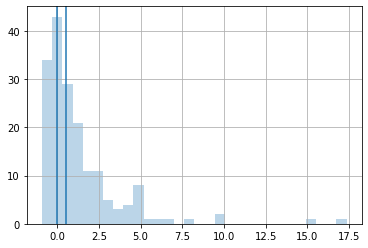

In [160]:
eps = 1e-10
perc_increase=((group1 - group2) / (group2+eps))
ax=perc_increase.hist(bins=30,alpha=0.3)
median = perc_increase.median()

ax.axvline(0)
ax.axvline(median,label='median')

In [144]:
scipy.stats.mannwhitneyu(group1,group2,alternative='greater')

MannwhitneyuResult(statistic=20067.0, pvalue=2.40974550034658e-06)

In [142]:
n1 = len(group1)
n2 = len(group2)
r = 1 - (2 * u_stat) / (n1 * n2)
r

In [143]:
r

0.9997080651060949

In [124]:
max_of_mean_in_day.query('type==""')

,uid,day_for_field,type,field,values
0,40,1,within,0,0.018209
1,40,1,outside,0,0.016343
2,40,1,diff,0,0.001865
3,40,1,within,1,0.090527
4,40,1,outside,1,0.034651
...,...,...,...,...,...
526,95,3,outside,0,0.034782
527,95,3,diff,0,0.030817
528,95,3,within,1,0.055792
529,95,3,outside,1,0.037570


In [129]:
xx=max_of_mean_in_day.query('type=="diff"')['values']

<Axes: >

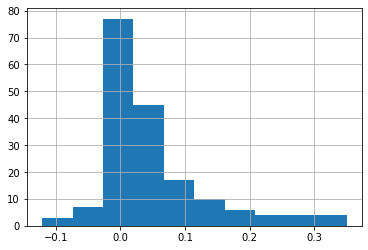

In [132]:
xx.hist()

In [134]:
scipy.stats.wilcoxon(xx,alternative='greater')

WilcoxonResult(statistic=13636.0, pvalue=1.6302053836821693e-17)

<Axes: xlabel='type', ylabel='values'>

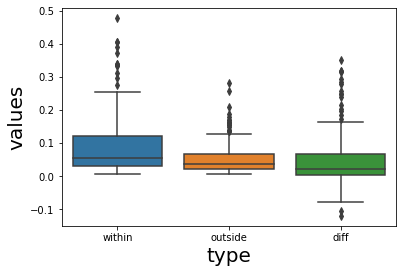

In [125]:
sns.boxplot(data=max_of_mean_in_day,x='type',y='values')

<Axes: >

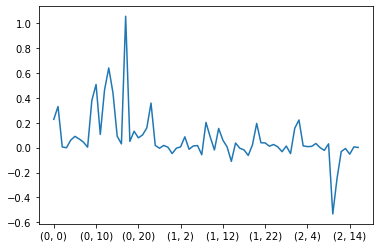

In [101]:
pre_day_activation_d_all.loc[slice(None),slice(None),'diff'].mean(axis=0).plot()

In [13]:
exp_ind=('CA1',slice(None),0)
per_cell_metrics_oneexp = per_cell_metrics.loc[exp_ind,:]
row=per_cell_metrics_oneexp.query('si>1').sample(1,random_state=3)
print(row)
region, exp, day,isnovel,uid=ind=row.index[0]
# region,exp = exp_ind

# region = 'CA1'#'CA3'
# exp = 0#0
# uid = 64#21
# isnovel = 0#1

# prep all days
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
X_df_ = X_df_.fillna(axis=0,method='ffill')
maxval = np.quantile(X_df_.dropna(),0.99)
X_df_[X_df_ > maxval] = X_df_

get_field_day = 1
compare_day = 0

X_df_compare = X_df_.loc[:,[compare_day]]

X_df_field = X_df_.loc[:,[get_field_day]] #X_df_# 
# X_df_field = X_df_# X_df_.loc[:,X_df_.columns.get_level_values(0)!=2] #
# norm_factor = np.quantile(X_df_field.dropna().values,0.99)
# X_df = X_df_field /norm_factor
X_df = X_df_field

reload(unmf)
n_basis = 20#20
lam_beta=20
lam_beta_cross=20.
# lam_beta=lam_beta_cross = 20.#1.
lam_h = .1 # 0.1
rtol=1e-3
# lam_beta_cross = 10.#0.1
norm_W='mean' # 'max'
W_hat_ma, H_hat_ma,X_hat, loss_history = unmf.do_unimodal_nmf_wrapper(X_df,ma_thresh=0.05,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=rtol,
                                                                verbose=True,norm_H=None,norm_W=norm_W
                                                               )

recon = loss_history['reconstruction'].iloc[-1]

field_range=rba.get_field(W_hat_ma,extend=2,max_thresh=0.2)


                     si     fr_cv   mean_fr  sparsity
CA1 5 0 1 364  1.510655  0.573252  0.014409  3.455849
iter0--tot: 275.96613, recon: 58.31815, reg_beta: 0.74321, reg_H: 12.93326, reg_beta_cross: 203.97152
iter1--tot: 451.49258, recon: 43.95479, reg_beta: 2.25097, reg_H: 12.03003, reg_beta_cross: 393.25679
iter2--tot: 417.36365, recon: 40.27395, reg_beta: 3.15496, reg_H: 10.80608, reg_beta_cross: 363.12866
iter3--tot: 391.95912, recon: 40.63193, reg_beta: 2.90389, reg_H: 10.96827, reg_beta_cross: 337.45502
iter4--tot: 384.81542, recon: 40.73858, reg_beta: 2.82955, reg_H: 11.01008, reg_beta_cross: 330.23722
iter5--tot: 384.01203, recon: 40.74986, reg_beta: 2.81526, reg_H: 11.03104, reg_beta_cross: 329.41586
iter6--tot: 383.85601, recon: 40.75174, reg_beta: 2.81097, reg_H: 11.03679, reg_beta_cross: 329.25649
success=True


In [53]:
field_range

,start,end,window_start,window_end
0,0,23,0,46
1,49,95,23,95


In [52]:
reload(rba)
field_range=rba.get_field(W_hat_ma,extend=2,max_thresh=0.2,out_of_field_size_thresh=10)

(None, <Axes: xlabel='Position'>)

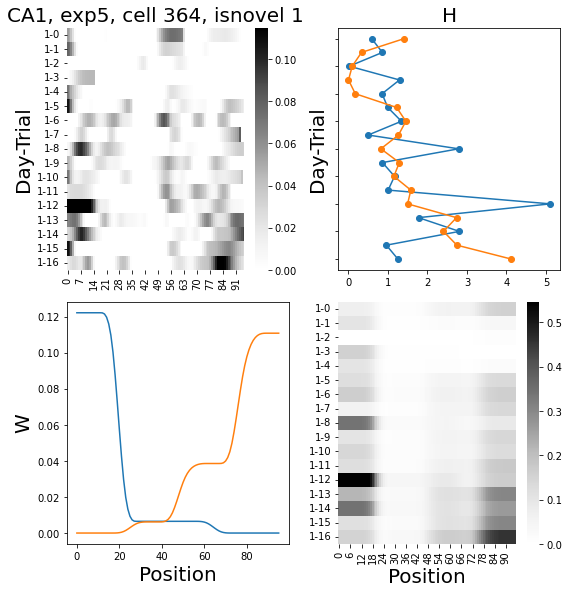

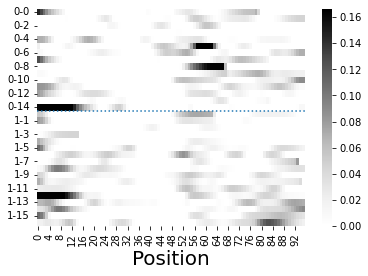

In [35]:
reload(unmf)
fig,axs=unmf.plot_ratemap_and_wh(X_df_field,W_hat_ma,H_hat_ma,X_hat=X_hat,fig=None,axs=None,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)
fig,ax=ph.heatmap(X_df_.T)
ph.plot_day_on_heatmap(X_df_.T,ax=ax)

In [39]:
pre_day_activation=rba.get_activation_all_field(X_df_compare,field_range)

In [76]:
X_df_

0                                                                   \
          0         1    2    3         4         5         6         7    8    
0   0.146139  0.000000  0.0  0.0  0.069416  0.020208  0.009420  0.126693  0.0   
1   0.129721  0.000000  0.0  0.0  0.069282  0.000199  0.006796  0.106408  0.0   
2   0.106787  0.000000  0.0  0.0  0.066187  0.000000  0.002173  0.085598  0.0   
3   0.085763  0.000000  0.0  0.0  0.055700  0.000000  0.000000  0.067542  0.0   
4   0.069341  0.000000  0.0  0.0  0.037197  0.000000  0.000000  0.051809  0.0   
..       ...       ...  ...  ...       ...       ...       ...       ...  ...   
91  0.000000  0.040087  0.0  0.0  0.000181  0.000000  0.041879  0.000000  0.0   
92  0.000000  0.042880  0.0  0.0  0.000000  0.000000  0.052931  0.000000  0.0   
93  0.000000  0.044402  0.0  0.0  0.000000  0.000000  0.063256  0.000000  0.0   
94  0.000000  0.045025  0.0  0.0  0.000000  0.000000  0.069956  0.000000  0.0   
95  0.000000  0.045025  0.0  0.0  0.000000  0.000000  0.069956  0.000000  0.0   

              ...         1                                                    \
          9   ...        7         8         9         10        11        12   
0   0.007224  ...  0.000000  0.007215  0.045751  0.069245  0.022048  0.166473   
1   0.006875  ...  0.000000  0.012554  0.041943  0.057036  0.024147  0.166473   
2   0.005759  ...  0.000000  0.025277  0.033255  0.037963  0.026538  0.166473   
3   0.003439  ...  0.000000  0.046167  0.019481  0.021241  0.027699  0.166473   
4   0.000011  ...  0.004165  0.069745  0.003586  0.012482  0.027868  0.166473   
..       ...  ...       ...       ...       ...       ...       ...       ...   
91  0.022422  ...  0.050014  0.031427  0.000000  0.025954  0.000000  0.006942   
92  0.020736  ...  0.054674  0.033579  0.000000  0.028130  0.000000  0.006361   
93  0.019880  ...  0.080843  0.034486  0.000000  0.030314  0.000000  0.005710   
94  0.019675  ...  0.000000  0.034227  0.000000  0.038857  0.000000  0.004852   
95  0.019675  ...  0.000000  0.033419  0.000000  0.000000  0.000000  0.003964   

                                            
          13        14        15        16  
0   0.064287  0.030523  0.107732  0.017053  
1   0.065552  0.032759  0.099316  0.019629  
2   0.068283  0.038023  0.079995  0.024190  
3   0.071663  0.047873  0.048048  0.028137  
4   0.072516  0.062812  0.009319  0.027823  
..       ...       ...       ...       ...  
91  0.074659  0.065828  0.049350  0.046186  
92  0.075450  0.073430  0.044299  0.038489  
93  0.074435  0.080226  0.039557  0.031611  
94  0.072438  0.086192  0.035203  0.025068  
95  0.070549  0.090537  0.032003  0.019966  

[96 rows x 32 columns]

In [81]:
reload(rba)
reload(unmf)
pre_day_activation_d = rba.fit_unmf_and_get_activation_all_comparisons_onecell(X_df_)

success=True
3
   start  end  window_start  window_end
0      0   19             0          38
1     46   66            36          68
2     68   95            66          95
   start  end  window_start  window_end
0      0   19             0          38
1     46   66            36          68


<Axes: >

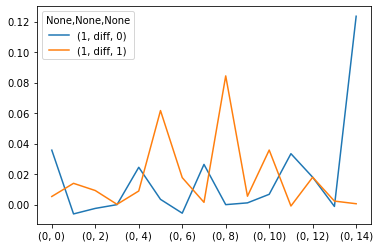

In [82]:
pre_day_activation_d.loc[(slice(None),'diff'),:].T.plot()

In [58]:
pre_day_activation

0                                                    \
                 0         1         2         3         4         5    
within  0  0.029759  0.001918  0.000000  0.000000  0.034362  0.002888   
outside 0  0.000342  0.003419  0.008008  0.000000  0.002402  0.010977   
diff    0  0.029416 -0.001501 -0.008008  0.000000  0.031959 -0.008089   
within  1  0.017005  0.020190  0.007745  0.000087  0.009205  0.039714   
outside 1  0.000328  0.004083  0.007508  0.000000  0.002618  0.012963   
diff    1  0.016677  0.016107  0.000237  0.000087  0.006587  0.026751   

                                                                       \
                 6         7         8         9         10        11   
within  0  0.004387  0.021970  0.000000  0.000971  0.005648  0.027823   
outside 0  0.010116  0.000068  0.000000  0.000000  0.000000  0.000000   
diff    0 -0.005729  0.021901  0.000000  0.000971  0.005648  0.027823   
within  1  0.021460  0.016233  0.042262  0.028554  0.029716  0.020441   
outside 1  0.013471  0.000061  0.000000  0.000000  0.000550  0.000000   
diff    1  0.007990  0.016172  0.042262  0.028554  0.029166  0.020441   

                                         
                 12        13        14  
within  0  0.030338  0.000939  0.123479  
outside 0  0.002726  0.001323  0.009485  
diff    0  0.027612 -0.000384  0.113994  
within  1  0.011002  0.003865  0.000841  
outside 1  0.003651  0.001170  0.008391  
diff    1  0.007351  0.002695 -0.007549

<Axes: >

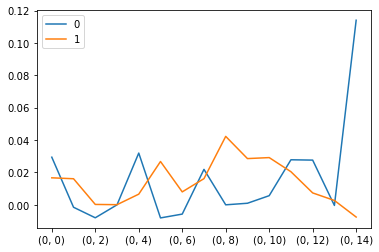

In [40]:
pre_day_activation.loc['diff'].T.plot()

In [16]:
field_range

,start,end,window_start,window_end
0,0,23,0,46
1,49,95,3,95
